In [2]:

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from sb3_contrib import  RecurrentPPO
from stable_baselines3.common.vec_env import SubprocVecEnv


In [5]:
class SDEEnv_train_3(gym.Env):
    """ stochasticity added ,also tuned the rewards more, and also has a fixed episode length"""
    def __init__(self):
        super(SDEEnv_train_3, self).__init__()
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        
        # Actions are [u1, u2], both in some control range
        self.action_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        
        # Time step for numerical integration
        self.dt = 0.1
        
        # Initial values for state variables y1 and y2
        self.state = np.array([.1, .1])
        self.episode_length = 100000  # Maximum episode length
        self.current_step= 0
        
    def reset(self,seed = None,options = None):
        # Reset the state to initial values
        self.state = np.array([0.1, 0.1])
        self.current_step = 0
        return self.state

    def step(self, action):
        u1, u2 = action
        y1, y2 = self.state
        
        dt = self.dt
        
        # Deterministic part of the system (first equation)
        dy1 = ( -1*(u1 + 0.5 * u1**2 )* y1 + 0.5 * u2 * y2 / (y1 + y2) ) * dt
        
        # Stochastic part of the second equation
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener process for stochastic term
        dy2 = (u1 * y1 - 0.7 * u2 * y1) * dt  #+ 0*(0.1 * np.sqrt(y1) ) * dW
        
        
        # Update states
        y1 += dy1
        y2 += dy2
        
        # Ensure non-negative concentrations
        #y1 = max(0, y1)
        #y2 = max(0, y2)
        
        self.state = np.array([y1, y2])
        
        # Reward is based on maximizing y2
        # if y2<0.2:
        #     reward= -1 + y2*5
        # else:
        #     reward = y2*5       
        reward = y2
        # Done if the system has run too long or if values go out of bounds
        done = False
        
        if y1 < 0 or y2 < 0:
            reward = -100
            done = True
            
        self.current_step += 1
        
        if self.current_step >= self.episode_length:
            done = True
        
        #so terminate when exceeds episode length 
        
        return self.state, reward, done, False, {}

    def render(self):
        # Optional rendering for visualization, not essential
        print(f"State: y1={self.state[0]}, y2={self.state[1]}")


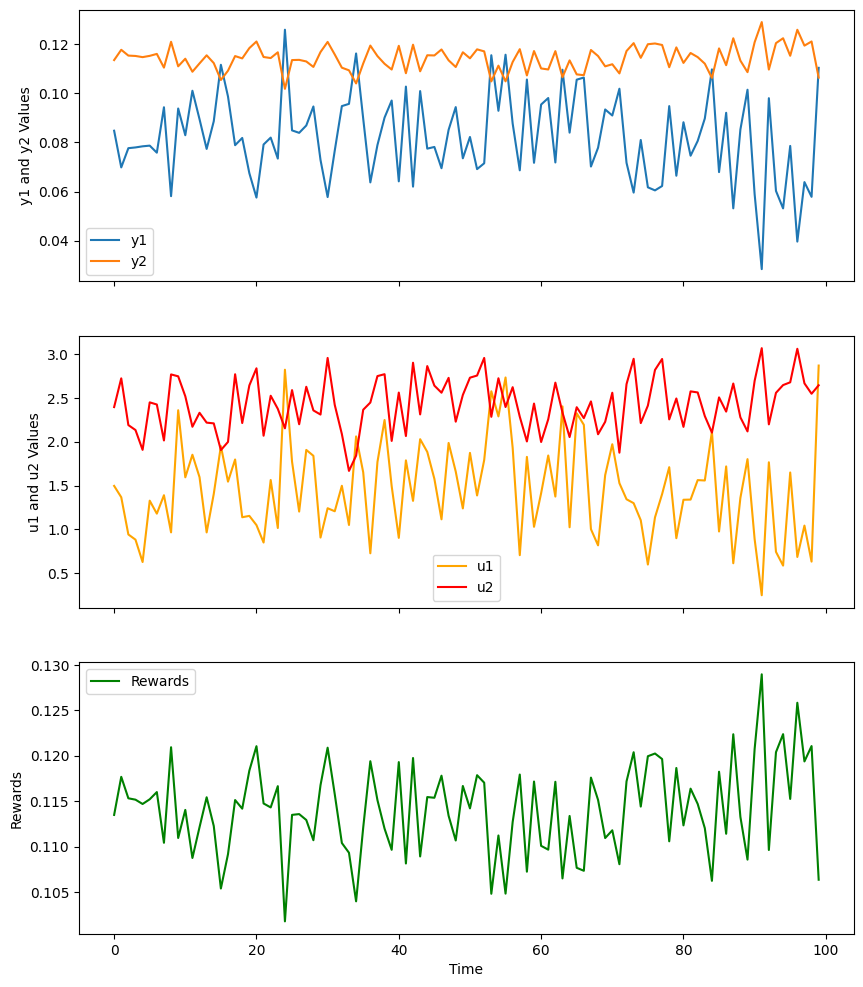

In [6]:
path=r"D:\ALL CODES\REINCEFORCEMENT LEARNING\Papers\PAPERS\chemE RL papers\deep learning for batch bioporcesss\RecurrentPPO_V2.zip"
env_test=SDEEnv_train_3()
model_trained=RecurrentPPO.load(path,env=env_test)
y1_values=[]
y2_values=[]
u1_values=[]
time=[]
u2_values=[]
rewards=[]
for t in range(100):
    obs = env_test.reset()
    action, _states = model_trained.predict(obs)
    obs, reward, done, _, _ = env_test.step(action)
    rewards.append(reward)
    y1_values.append(obs[0])
    y2_values.append(obs[1])
    u1_values.append(action[1])
    u2_values.append(action[0])
    time.append(t)


# Plot the results
import matplotlib.pyplot as plt

# Assuming you have the rewards data in a variable called rewards
# Create a figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot y1 and y2 in the first subplot
ax1.plot(time, y1_values, label='y1')
ax1.plot(time, y2_values, label='y2')
ax1.set_ylabel('y1 and y2 Values')
ax1.legend()

# Plot u1 and u2 in the second subplot
ax2.plot(time, u1_values, label='u1', color='orange')
ax2.plot(time, u2_values, label='u2', color='red')
ax2.set_ylabel('u1 and u2 Values')
ax2.legend()

# Plot rewards in the third subplot
ax3.plot(time, rewards, label='Rewards', color='green')
ax3.set_xlabel('Time')
ax3.set_ylabel('Rewards')
ax3.legend()

# Show the plot
plt.show()